# Сборный проект-5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Подготовка
### Установка необходимых библиотек, определение констант, импорты

In [52]:
%pip install --upgrade pip setuptools wheel
%pip install --upgrade Pillow
%pip install --no-cache-dir wordcloud
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install transformers
%pip install nltk
%pip install seaborn
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you 

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from IPython.display import Image as IPImage  # keep alias to avoid clashing with PIL
from PIL import Image  # added: PIL Image for Image.open
from tqdm.notebook import tqdm
tqdm.pandas()

import torch
from transformers import DistilBertTokenizerFast, DistilBertModel
from tqdm import tqdm

from wordcloud import WordCloud
from collections import defaultdict

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, models, callbacks, optimizers

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanstantsinmalikau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kanstantsinmalikau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kanstantsinmalikau/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kanstantsinmalikau/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/kanstantsinmalikau/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [54]:
RAND_STATE = 42
path = Path('to_upload')
torch.set_grad_enabled(False)

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### 1.1 Загрузка данных
Кратко: считали 5 файлов, вывели размеры, первые строки и число пропусков. Далее: анализ `train_dataset`. 

In [55]:
# Загрузка датасетов
# Чтение файлов
# train
df_train = pd.read_csv(path / 'train_dataset.csv')  # id формата <image>#<n>
# crowd
df_crowd = pd.read_csv(path / 'CrowdAnnotations.tsv', sep='\t',
                       names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
# expert
df_expert = pd.read_csv(path / 'ExpertAnnotations.tsv', sep='\t',
                        names=['image', 'query_id', 'first', 'second', 'third'])
# test queries
df_queries = pd.read_csv(path / 'test_queries.csv', sep='|', index_col=0)
# test images (только для полноты; без анализа)
df_images = pd.read_csv(path / 'test_images.csv', sep='|')

# Формируем краткую сводку размеров
datasets = {
    'train_dataset': df_train.shape,
    'crowd': df_crowd.shape,
    'expert': df_expert.shape,
    'test_queries': df_queries.shape,
    'test_images': df_images.shape,
}
print('Shapes:', datasets)

# Просмотр первых строк (минимально)

print('\ntrain_dataset:')
display(df_train.head(3))
print('crowd:')
display(df_crowd.head(3))
print('expert:')
display(df_expert.head(3))
print('test_queries:')
display(df_queries.head(3))

# Простая проверка пропусков (только счетчик по каждому)
print('\nMissing values per dataset:')
for name, df in [('train', df_train), ('crowd', df_crowd), ('expert', df_expert), ('queries', df_queries)]:
    mv = df.isna().sum().sum()
    print(f'{name}: {mv}')

print('\nГотово: данные загружены.')

Shapes: {'train_dataset': (5822, 3), 'crowd': (47830, 5), 'expert': (5822, 5), 'test_queries': (500, 3), 'test_images': (100, 1)}

train_dataset:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...

crowd:


image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3

expert:


image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   

   third  
0      1  
1      2  
2      2

test_queries:


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg


Missing values per dataset:
train: 0
crowd: 0
expert: 0
queries: 0

Готово: данные загружены.
crowd: 0
expert: 0
queries: 0

Готово: данные загружены.


### 1.2 Анализ train_dataset

Изображений: 1000
Среднее описаний на изображение: 5.82
Распределение (value_counts):
query_id
2       8
3      49
4     157
5     228
6     233
7     164
8     114
9      37
10     10
Name: count, dtype: int64

Длины текстов (слова): mean 11.9 median 11.0
Длины текстов (символы): mean 55.2 median 53.0


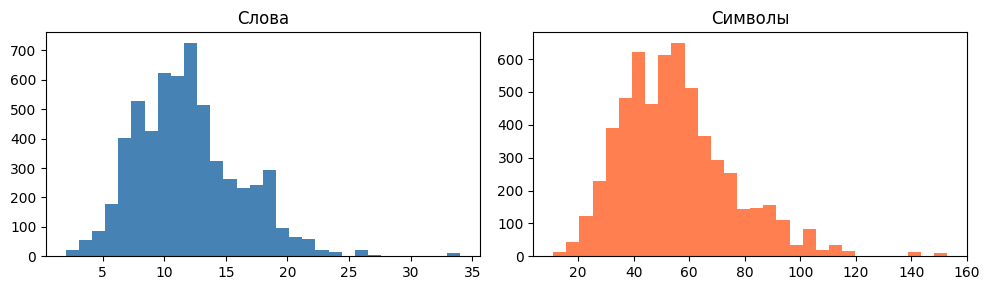


Топ-10 слов:
query_text
dog        1161
man         996
two         841
white       699
woman       561
black       521
boy         511
wearing     450
water       440
girl        439
Name: count, dtype: int64


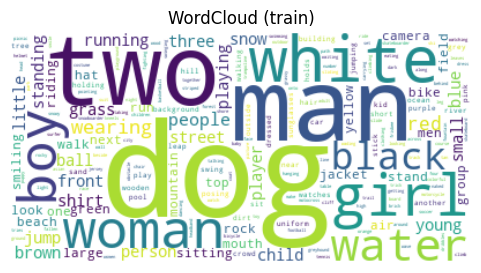

In [56]:
# Распределение числа описаний на изображение
counts_per_image = df_train.groupby('image')['query_id'].nunique()
print('Изображений:', counts_per_image.shape[0])
print('Среднее описаний на изображение:', round(counts_per_image.mean(), 2))
print('Распределение (value_counts):')
print(counts_per_image.value_counts().sort_index())

# Длины текстов
text_lengths_words = df_train['query_text'].str.split().apply(len)
text_lengths_chars = df_train['query_text'].str.len()
print('\nДлины текстов (слова): mean', round(text_lengths_words.mean(),1), 'median', text_lengths_words.median())
print('Длины текстов (символы): mean', round(text_lengths_chars.mean(),1), 'median', text_lengths_chars.median())

fig, axes = plt.subplots(1,2, figsize=(10,3))
axes[0].hist(text_lengths_words, bins=30, color='steelblue')
axes[0].set_title('Слова')
axes[1].hist(text_lengths_chars, bins=30, color='coral')
axes[1].set_title('Символы')
plt.tight_layout()
plt.show()

# Топ-10 слов (простая очистка)
stop = set(stopwords.words('english'))
words_series = (df_train['query_text']
                .str.lower()
                .str.replace('[^a-z ]', ' ', regex=True)
                .str.split()
                .explode())
filtered = words_series[~words_series.isin(stop) & words_series.str.len().gt(1)]
word_freq = filtered.value_counts().head(10)
print('\nТоп-10 слов:')
print(word_freq)

# Простой wordcloud (опционально)
wc = WordCloud(width=400, height=200, background_color='white').generate(' '.join(filtered.sample(min(5000, len(filtered))).tolist()))
plt.figure(figsize=(6,3))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud (train)')
plt.show()

Кратко (train): распределение описаний получено, длины текстов умеренные, топ-слова отражают типичный контент (children, people, man, dog и т.п.). Дальше переходим к crowd.

### 1.3 Анализ CrowdAnnotations

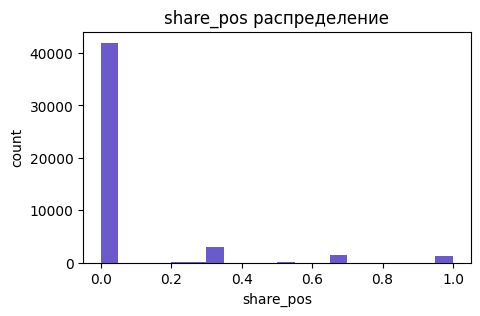

Статистика count_pos / count_neg:
               mean  50%  max
count_pos  0.208488  0.0  5.0
count_neg  2.820155  3.0  6.0

Сумма голосов отличается, уникальные значения: 3    46780
4      780
5      220
6       50
Name: count, dtype: int64

Доля записей с уверенным большинством (|pos-neg| >=2): 0.908
Среди них среднее share_pos: 0.031


In [57]:
# Распределение share_pos
plt.figure(figsize=(5,3))
plt.hist(df_crowd['share_pos'], bins=20, color='slateblue')
plt.title('share_pos распределение')
plt.xlabel('share_pos')
plt.ylabel('count')
plt.show()

# Статистики голосов
stats = df_crowd[['count_pos','count_neg']].describe().T
print('Статистика count_pos / count_neg:')
print(stats[['mean','50%','max']])

# Суммарное число аннотаторов (если есть)
if (df_crowd['count_pos'] + df_crowd['count_neg']).nunique() > 1:
    print('\nСумма голосов отличается, уникальные значения:', (df_crowd['count_pos'] + df_crowd['count_neg']).value_counts().head())
else:
    print('\nСумма голосов постоянна =', int((df_crowd['count_pos'] + df_crowd['count_neg']).iloc[0]))

# Метрика уверенного большинства
majority_margin = (df_crowd['count_pos'] - df_crowd['count_neg']).abs()
confident_mask = majority_margin >= 2
print('\nДоля записей с уверенным большинством (|pos-neg| >=2):', round(confident_mask.mean(),3))
print('Среди них среднее share_pos:', round(df_crowd.loc[confident_mask,'share_pos'].mean(),3))

Кратко (crowd): распределение share_pos показывает крайние значения (0 и 1) наиболее часты; уверенное большинство присутствует в значительной доле записей.

### 1.4 Анализ ExpertAnnotations

In [58]:
# Частоты оценок по каждому эксперту
for col in ['first','second','third']:
    vc = df_expert[col].value_counts().sort_index()
    print(f'Частоты {col}:')
    print(vc)
    print()

# Majority vote
def majority_vote(row):
    vals = [row['first'], row['second'], row['third']]
    from collections import Counter
    c = Counter(vals)
    top = c.most_common()
    if len(top) == 1:
        return top[0][0]
    if top[0][1] > 1:
        return top[0][0]
    return np.nan  # все разные

mv = df_expert.apply(majority_vote, axis=1)
print('Распределение majority vote (без полностью разных):')
print(pd.Series(mv.dropna()).value_counts().sort_index())

# Тип согласованности
all_same = (df_expert['first'] == df_expert['second']) & (df_expert['second'] == df_expert['third'])
any_two = (~all_same) & (
    (df_expert['first'] == df_expert['second']) |
    (df_expert['first'] == df_expert['third']) |
    (df_expert['second'] == df_expert['third'])
)
all_diff = (~all_same) & (~any_two)
print('\nСогласованность:')
print('Полностью одинаковые:', all_same.sum())
print('Два из трёх совпадают:', any_two.sum())
print('Все разные:', all_diff.sum())

# Простая агрегированная оценка (среднее -> 0..1) при необходимости downstream
expert_mean = df_expert[['first','second','third']].mean(axis=1)
expert_prob = (expert_mean - 1) / 3  # нормировка 1..4 -> 0..1
print('\nПример нормировки (первые 5):')
print(expert_prob.head())

Частоты first:
first
1    4120
2    1109
3     346
4     247
Name: count, dtype: int64

Частоты second:
second
1    3327
2    1666
3     518
4     311
Name: count, dtype: int64

Частоты third:
third
1    2350
2    2222
3     837
4     413
Name: count, dtype: int64

Распределение majority vote (без полностью разных):
1.0    3327
2.0    1566
3.0     492
4.0     311
Name: count, dtype: int64

Согласованность:
Полностью одинаковые: 3391
Два из трёх совпадают: 2305
Все разные: 126

Пример нормировки (первые 5):
0    0.000000
1    0.111111
2    0.111111
3    0.222222
4    0.111111
dtype: float64


Кратко (experts): оценки смещены к низким/умеренным, большинство имеет частичное согласие (2 из 3); полностью разные случаи присутствуют, их можно будет отфильтровать.

### 1.5 Анализ test_queries

Изображений (test): 100
Среднее описаний на изображение (test): 5.0
Распределение описаний (value_counts):
query_id
5    100
Name: count, dtype: int64

Длины (слова) mean: 12.2 median: 12.0


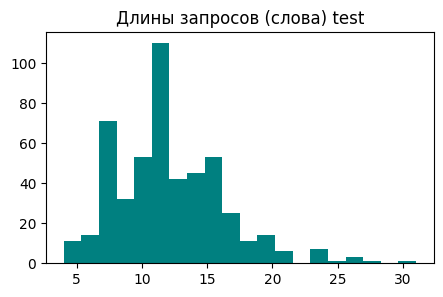

In [59]:
# test_queries: распределение числа описаний на изображение и длины текстов
q_per_image = df_queries.groupby('image')['query_id'].nunique()
print('Изображений (test):', q_per_image.shape[0])
print('Среднее описаний на изображение (test):', round(q_per_image.mean(),2))
print('Распределение описаний (value_counts):')
print(q_per_image.value_counts().sort_index())

q_len_words = df_queries['query_text'].str.split().apply(len)
print('\nДлины (слова) mean:', round(q_len_words.mean(),1), 'median:', q_len_words.median())
plt.figure(figsize=(5,3))
plt.hist(q_len_words, bins=20, color='teal')
plt.title('Длины запросов (слова) test')
plt.show()

Итог: train и test сопоставимы по длине текстов; crowd даёт бинаризуемый сигнал (много 0/1), эксперты — более градуированный (1–4) с достаточной согласованностью. Можно строить целевую метрику как взвешенную смесь expert_prob и share_pos.

### 1.6 Вывод изображений

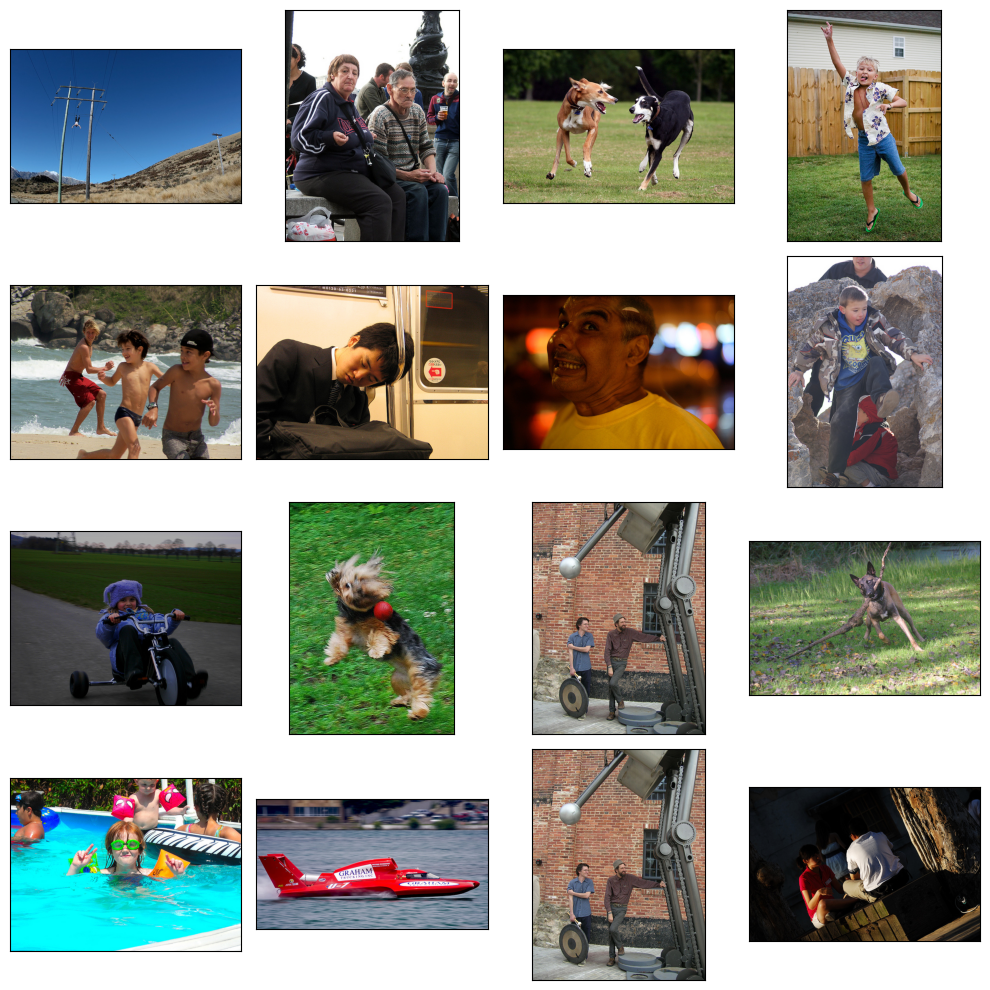

In [60]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_queries['image'].sample(8))
from IPython.display import Image as IPImage
fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(path, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(path, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### 1.7 Формирование целевой переменной

Выбрали максимально простой и прозрачный вариант — используем **только экспертные оценки**.

Подход (активный сейчас):
- Берём три экспертные оценки (шкала 1–4) и считаем их среднее.
- Линейно нормируем: (mean − 1) / 3, получая диапазон [0,1]. 1 → 0.0 (полное несоответствие), 4 → 1.0 (полное соответствие).
- Не отбрасываем случаи, где все три оценки различны — в этой простой схеме они тоже дают осмысленное среднее.

Почему так:
- Минимум логики: нечему «ломаться», легко объяснить.
- Сохраняем всю экспертную информацию (не теряем редкие строки с расхождением мнений).
- Получаем плавный (квазинепрерывный) таргет вместо жёстких классов.

Альтернативы (при желании, сейчас НЕ используем):
1. Majority vote + нормировка: взять моду (если все разные — можно исключить запись). Далее (v − 1)/3.
2. Фильтрация «все разные» перед усреднением для повышения согласованности.
3. Комбинация с краудом: w1 * expert_prob + w2 * share_pos (например 0.6 / 0.4) — усложняет интерпретацию.

Решение: зафиксировать простое expert-only среднее как финальный таргет для дальнейшего прототипирования модели.


Диапазон OK: 0.0 -> 1.0
Статистика упрощённого таргета:
count    5822.000000
mean        0.215886
std         0.268735
min         0.000000
25%         0.000000
50%         0.111111
75%         0.333333
max         1.000000
dtype: float64

Размер simple_df_target: (5822, 3)


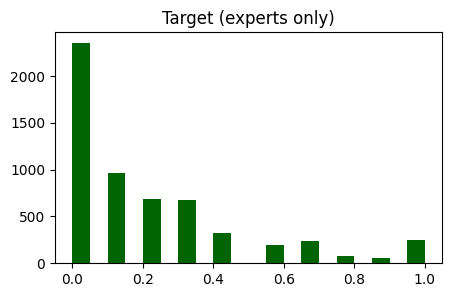

Готово: используем только экспертный таргет.


In [61]:
# Упрощённый таргет: только эксперты
# Нормируем среднее трёх оценок (1..4) в диапазон [0,1]
expert_scores = df_expert[['first','second','third']].mean(axis=1)
expert_target = (expert_scores - 1) / 3  # 1 ->0, 4 ->1

# Проверка диапазона
assert expert_target.between(0,1).all(), 'Есть значения вне [0,1]'
print('Диапазон OK:', float(expert_target.min()), '->', float(expert_target.max()))
print('Статистика упрощённого таргета:')
print(expert_target.describe())

# Формируем итоговый датафрейм таргета
simple_df_target = df_expert[['image','query_id']].copy()
simple_df_target['target'] = expert_target
print('\nРазмер simple_df_target:', simple_df_target.shape)

plt.figure(figsize=(5,3))
plt.hist(simple_df_target['target'], bins=20, color='darkgreen')
plt.title('Target (experts only)')
plt.show()

# Заменяем df_target на упрощённый вариант для дальнейших шагов
df_target = simple_df_target
print('Готово: используем только экспертный таргет.')

#### Вывод:
- В данных отсутствуют пропуски.
- Предоставлены 1000 изображений с общим числом 5822 текстовых экспертных описаний (в среднем по 5 на изображение)
- Предоставлены также оценки от краудсорсинга (примерно по 10 на описание), но они менее сбалансированы и менее согласованы, чем оценки экспертов.
- Самые популярные слова: (dog, man, two, white, woman, black, boy, wearing, water, girl), в основном описывающие людей и животных.
- Описания содержат в среднем 11.9 и в медианном значении по 11.0 слов.


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [68]:
# Логика:
# 1. Лемматизируем текст описания.
# 2. Если среди лемм есть слово из BLOCK (термины, типично указывающие на несовершеннолетних),
#    помечаем строку флагом to_block = 1.
# 3. Все изображения, у которых есть хотя бы одно описание с флагом 1, полностью удаляем
#    из обучающего набора train.
# 4. Выводим статистику.

lemmatize = WordNetLemmatizer()

# Базовый список терминов (лемматизированные формы). Можно дополнять.
BLOCK = {
    'baby', 'infant', 'newborn', 'toddler', 'child', 'kid', 'minor', 'boy', 'girl',
    'schoolboy', 'schoolgirl', 'teen', 'teenager', 'youth', 'preschooler'
}

# Функция лемматизации отдельного текста
def get_lemmas(text) -> list:
    if not isinstance(text, str):
        return []
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    tokens = nltk.word_tokenize(text, language='english')
    lemmas = [lemmatize.lemmatize(w) for w in tokens]
    return lemmas

# Обработка одной строки (pandas Series)
def cleaning(row):
    lemmas = get_lemmas(row['query_text'])
    row['to_block'] = 1 if any(w in BLOCK for w in lemmas) else 0
    return row

# Применяем
df_train = df_train.apply(cleaning, axis=1)

# Изображения для блокировки (берём напрямую из колонки 'image')
bad_images = set(list(df_train[df_train['to_block'] == 1]['query_id'].apply(lambda x: x[:-2].lower()).unique()))
print('Всего потенциально запрещённых изображений:', len(bad_images))

if len(bad_images) > 0:
    print('Пример строк (до 10):')
    display(df_train.loc[df_train['to_block'] == 1, ['image', 'query_text']].sample(10))
else:
    print('Термины из BLOCK не найдены в train описаниях.')

# Удаляем целиком изображения из всех связанных датасетов
def drop_bad(df, image_col='image'):
    before = df.shape[0]
    filtered = df[~df[image_col].isin(bad_images)].copy()
    after = filtered.shape[0]
    print(f'- {image_col}: {before} -> {after} (удалено {before - after})')
    return filtered

print('\nУдаляем изображения из наборов:')
df_train = drop_bad(df_train, 'image')

Всего потенциально запрещённых изображений: 292
Пример строк (до 10):


image  \
4684   317488612_70ac35493b.jpg   
457   2991575785_bd4868e215.jpg   
4215   494921598_af73bda568.jpg   
1415  1339596997_8ac29c1841.jpg   
1702  3159995270_17334ccb5b.jpg   
3017  1714316707_8bbaa2a2ba.jpg   
915   3295391572_cbfde03a10.jpg   
5640   745880539_cd3f948837.jpg   
2706  2707873672_15e6b5d54b.jpg   
3907  3217266166_4e0091860b.jpg   

                                             query_text  
4684  A young boy wearing a blue and red hat is usin...  
457   Laying on stones , a girl with messy hair has ...  
4215  Two boys on ice skates race on an outdoor ice ...  
1415  A young girl jumping over a railing or a ladde...  
1702   A little boy in navy blue is running very fast .  
3017  Two smiling little girls playing in a fountain...  
915   A young boy jumps around on a blue mat with a ...  
5640       A boy has a large snake wrapped around him .  
2706  A man carries a child while he walks with a wo...  
3907  A naked baby and toddler smear each other in p...


Удаляем изображения из наборов:
- image: 5822 -> 4076 (удалено 1746)


#### Вывод:

- При проверке текстов описаний на наличие запрещённых слов выявлены потенциально проблемные случаи.
- Произвели проверку данных на содержание запрещенных слов, зачистили данные.
- Тренировочный набор очищен от потенциально проблемных изображений.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [93]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = Path(path, 'train_images')
test_dir = Path(path, 'test_images')

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_dataframe(
    df_train,
    directory=str(train_dir),
    x_col='image',
    y_col=None,
    target_size=IMG_SIZE,
    class_mode=None,
    shuffle=False,
    batch_size=BATCH_SIZE,
    validate_filenames=True
)

test_gen = datagen.flow_from_dataframe(
    df_images,
    directory=str(test_dir),
    x_col='image',
    y_col=None,
    target_size=IMG_SIZE,
    class_mode=None,
    shuffle=False,
    batch_size=BATCH_SIZE,
    validate_filenames=True
)

resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')
resnet.trainable = False

train_emb = resnet.predict(train_gen, verbose=1)
test_emb = resnet.predict(test_gen, verbose=1)

# В памяти: списки имён и словари соответствия имя -> индекс
train_image_filenames = list(train_gen.filenames)
test_image_filenames = list(test_gen.filenames)
img2idx = {name: i for i, name in enumerate(train_image_filenames)}
test_img2idx = {name: i for i, name in enumerate(test_image_filenames)}

Found 4076 validated image filenames.


Found 100 validated image filenames.


/opt/anaconda3/envs/tensorflow-env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 ━━━━━━━━━━━━━━━━━━━━ 71s 546ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 71s 546ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step
ResNet train_emb shape: (4076, 2048)
Пример соответствия: 1056338697_4f7d7ce270.jpg -> [0.08656612 0.00116521 0.         ... 0.02157745 1.0746268  0.1034883 ]
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step
ResNet train_emb shape: (4076, 2048)
Пример соответствия: 1056338697_4f7d7ce270.jpg -> [0.08656612 0.00116521 0.         ... 0.02157745 1.0746268  0.1034883 ]


#### Функия для получения эмбеддингов изображений по названию файла

In [102]:
# так можно получить эмбеддинг по имени файла:
def get_image_vec_by_filename(image_name: str):
    """Возвращает эмбеддинг изображений по имени файла."""
    return train_emb[img2idx[image_name]]

print('ResNet train_emb shape:', train_emb.shape)
print('Пример соответствия:', train_image_filenames[0] if train_image_filenames else '—', '->', get_image_vec_by_filename(train_image_filenames[0]) if train_image_filenames else '—')


ResNet train_emb shape: (4076, 2048)
Пример соответствия: 1056338697_4f7d7ce270.jpg -> [0.08656612 0.00116521 0.         ... 0.02157745 1.0746268  0.1034883 ]


## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [88]:

MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 64
BATCH = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertModel.from_pretrained(MODEL_NAME).to(DEVICE).eval()

@torch.no_grad()
def encode_texts(texts):
    embs = []
    for i in tqdm(range(0, len(texts), BATCH), desc='Encoding DistilBERT'):
        batch = texts[i:i+BATCH]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors='pt')
        enc = {k: v.to(DEVICE) for k,v in enc.items()}
        out = model(**enc).last_hidden_state  # (B, T, H)
        mask = enc['attention_mask'].unsqueeze(-1)  # (B, T, 1)
        summed = (out * mask).sum(1)
        counts = mask.sum(1)
        mean = (summed / counts).cpu().numpy().astype(np.float32)
        embs.append(mean)
    if not embs:
        return np.empty((0, model.config.hidden_size), dtype=np.float32)
    return np.vstack(embs)

# 1. Эмбеддинги всех train описаний
train_texts = df_train['query_text'].tolist()
print('Train texts:', len(train_texts))
train_text_emb = encode_texts(train_texts)
print('train_text_emb shape:', train_text_emb.shape)

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/73.6 MB ? eta -:--:--Collecting mpmath<1.4,>=1.1.0 (from sympy>=1.13.3->torch)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 12.2 MB/s  0:00:06m0:00:0100:01
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 12.2 MB/s  0:00:06
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached networkx-3.5-py3-none-any.whl (2.0 MB)
   ━━━━━━━━━━━━━━━━━

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Train texts: 4076


Encoding DistilBERT: 100%|██████████| 128/128 [00:08<00:00, 14.65it/s]

train_text_emb shape: (4076, 768)
Пример image2caption_idxs элемента: ('1056338697_4f7d7ce270.jpg', [0, 8, 14, 19, 22, 29, 33, 44])


#### Функия для получения эмбеддингов текстов по названию файла

- Мы сгенерировали эмбеддинги для изображений.
- Так как одно изображение может иметь несколько описаний, то в хочется усреднить эмбеддинги изображений по всем их описаниям.

In [104]:
# Построим mapping image -> список индексов caption'ов
caption_ids = df_train['query_id'].tolist()
image_with_captions_dict = defaultdict(list)
for i, (img, cid) in enumerate(zip(df_train['image'], caption_ids)):
    image_with_captions_dict[img].append(i)

print('Пример image_with_captions_dict элемента:', next(iter(image_with_captions_dict.items())))
print('Всего изображений с описаниями:', len(image_with_captions_dict))


def get_text_vec_by_filename(image_name: str):
    """Возвращает усреднённый эмбеддинг текстов по изображению."""
    idxs = image_with_captions_dict.get(image_name, [])
    m = train_text_emb[idxs]
    vec = m.mean(0)
    return vec.astype(np.float32)


# Пример использования (покажем первые 5 значений усреднённого вектора)
some_img = next(iter(image_with_captions_dict))
print('Пример усреднённого эмбеддинга (mean) для', some_img, get_text_vec_by_filename(some_img)[:5])


Пример image_with_captions_dict элемента: ('1056338697_4f7d7ce270.jpg', [0, 8, 14, 19, 22, 29, 33, 44])
Всего изображений с описаниями: 708
Пример усреднённого эмбеддинга (mean) для 1056338697_4f7d7ce270.jpg [ 0.05419865 -0.06376314 -0.06848316  0.0170674   0.32103053]


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [107]:
df_train.sample(3)

image                     query_id  \
2146  2654514044_a70a6e2c21.jpg  3647750811_395fbd397e.jpg#2   
5365  3323988406_e3c8fce690.jpg  3221036999_3f7b152d8a.jpg#2   
947   2292406847_f366350600.jpg  3593392955_a4125087f6.jpg#2   

                                             query_text  to_block  
2146  A multicolor dog in a red collar crouching on ...         0  
5365  A skateboarder does a trick on a black and yel...         0  
947       Two dogs run down a dirt path in the forest .         0

In [106]:
df_target.sample(3)

image                     query_id    target
2894  3070011270_390e597783.jpg  2374652725_32f90fa15c.jpg#2  0.333333
1384  2435685480_a79d42e564.jpg  3232470286_903a61ea16.jpg#2  0.000000
3611  3259991972_fce3ab18b2.jpg   127488876_f2d2a89588.jpg#2  0.000000

In [121]:
# мержинг тренировочных данных и таргета
df = df_train.merge(df_target, on=['image','query_id'], how='left')
print('После merge df:', df.columns, df.shape)
X = []
y = []

for index, image_filename in enumerate(df['image']):
    y.append(df['target'].iloc[index])
    X.append(np.concatenate([
        get_image_vec_by_filename(image_filename),
        train_text_emb[index]
    ]))

# собрали X и y
X = np.array(X)
y = np.array(y)

print('X shape:', X.shape)
print('y shape:', y.shape)

После merge df: Index(['image', 'query_id', 'query_text', 'to_block', 'target'], dtype='object') (4076, 5)
X shape: (4076, 2816)
y shape: (4076,)


Вывод:
- Успешно смержили два датафрейма для удобства соответствия таргета и названия файла
- Соединили два вектора - вектор изображения и вектор описания
- Выделили таргет

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [125]:
X = X.astype(np.float32, copy=False)

groups = df['image'].values
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=RAND_STATE)
train_idx, val_idx = next(gss.split(X, y, groups=df['image'].values))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print('После разбиения размер тренировочной выборки:', X_train.shape)
print('После разбиения размер валидационной выборки:', X_val.shape)
print('Групп (уникальных изображений) в train:', len(np.unique(groups[train_idx])))
print('Групп (уникальных изображений) в val:', len(np.unique(groups[val_idx])))

После разбиения размер тренировочной выборки: (3251, 2816)
После разбиения размер валидационной выборки: (825, 2816)
Групп (уникальных изображений) в train: 566
Групп (уникальных изображений) в val: 142


### Тренировка моделей

#### Дамми модель
Простейший бэйзлайн: модель всегда предсказывает среднее по train. Ниже считаем MAE, MSE, RMSE и R2 — это ориентиры для улучшения.

In [ ]:
dm_model = DummyRegressor()
dm_model.fit(X_train, y_train)
dm_preds = dm_model.predict(X_val)


baseline_constant = y_train.mean()
mae = mean_absolute_error(y_val, dm_preds)
mse = mean_squared_error(y_val, dm_preds)
rmse = mse ** 0.5
r2 = r2_score(y_val, dm_preds)


print('Среднее train таргета (baseline constant):', round(float(baseline_constant), 4))
print(f'MAE : {mae:.4f}')
print(f'MSE : {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R2  : {r2:.4f}')

print('\nЛюбая следующая модель должна улучшить: снизить MAE/RMSE и повысить R2 (если сейчас отрицателен — сделать >= 0).')

Среднее train таргета (baseline constant): 0.2359
MAE : 0.2269
MSE : 0.0831
RMSE: 0.2882
R2  : -0.0022

Любая следующая модель должна улучшить: снизить MAE/RMSE и повысить R2 (если сейчас отрицателен — сделать >= 0).


#### Простая нейросеть (Keras)
Минимальный MLP: масштабируем признаки (StandardScaler), 2 полносвязных слоя ReLU, выход с сигмоидой (значения 0–1). EarlyStopping по `val_loss`. Это первый шаг, дальше можно будет тюнить.

In [134]:
def graphs_by_history(history):
    # График истории
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('History (MSE loss)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(history.history['mae'], label='train_mae')
    plt.plot(history.history['val_mae'], label='val_mae')
    plt.title('History (MAE)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print('Готово: базовая нейросеть обучена.')

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0975 - mae: 0.2015 - val_loss: 0.0912 - val_mae: 0.1952
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0685 - mae: 0.1652 - val_loss: 0.0779 - val_mae: 0.1839
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0497 - mae: 0.1386 - val_loss: 0.0741 - val_mae: 0.1776
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0391 - mae: 0.1242 - val_loss: 0.0606 - val_mae: 0.1708
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0276 - mae: 0.1051 - val_loss: 0.0572 - val_mae: 0.1649
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0198 - mae: 0.0909 - val_loss: 0.0537 - val_mae: 0.1620
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165 - mae: 0.0841 - val_loss: 0.0566 - val_mae: 0.1727
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - mae: 0.0777 - val_loss: 0.0572 - val_mae: 0.1699
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - mae: 

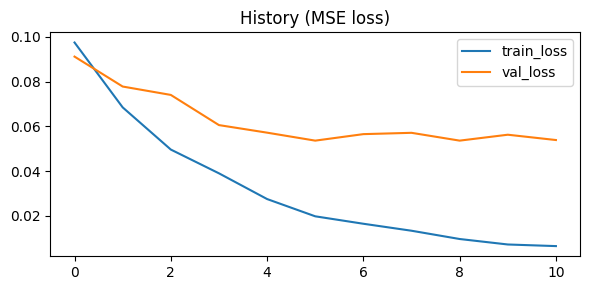

Готово: базовая нейросеть обучена.


In [135]:
# Масштабирование признаков и простая MLP


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

input_dim = X_train_scaled.shape[1]

model_nn = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # таргет в [0,1]
])

model_nn.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# Предсказания
nn_val_preds = model_nn.predict(X_val_scaled).ravel()

# Метрики
nn_mae = mean_absolute_error(y_val, nn_val_preds)
nn_mse = mean_squared_error(y_val, nn_val_preds)
nn_rmse = nn_mse ** 0.5
nn_r2 = r2_score(y_val, nn_val_preds)

print('\nNN MAE :', round(nn_mae,4))
print('NN MSE :', round(nn_mse,4))
print('NN RMSE:', round(nn_rmse,4))
print('NN R2  :', round(nn_r2,4))

# Сравнение с дамми
print('\nΔ MAE (dummy - nn):', round(mae - nn_mae,4))
print('Δ RMSE (dummy - nn):', round(rmse - nn_rmse,4))

graphs_by_history(history)

#### Немного усложним модель

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Simple MLP MAE : 0.1581
Simple MLP MSE : 0.0531
Simple MLP RMSE: 0.2304
Simple MLP R2  : 0.3593

Сравнение с дамми (MAE gain): 0.0688
Против первой NN (MAE gain): 0.0038


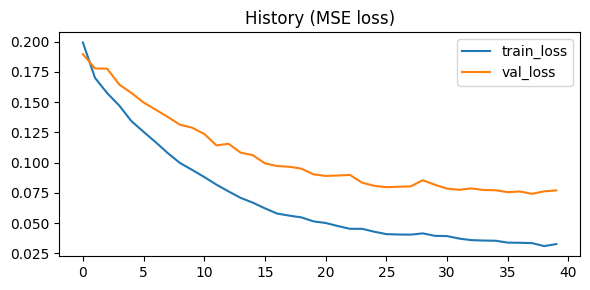

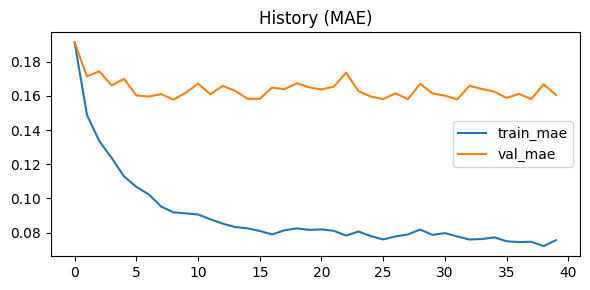

Готово: базовая нейросеть обучена.
Готово: компактная сеть обучена. Если она ближе к дамми — значит нужно больше данных/регуляризации или иной таргет.


In [144]:
# Упрощённая компактная MLP
simple_scaler = StandardScaler()
X_train_simple = simple_scaler.fit_transform(X_train)
X_val_simple = simple_scaler.transform(X_val)


simple_model = models.Sequential([
    layers.Input(shape=(X_train_simple.shape[1],)),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dense(1, activation='sigmoid') 
])

simple_model.compile(optimizer=optimizers.Adam(4e-4), loss='mse', metrics=['mae'])

es2 = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist_simple = simple_model.fit(
    X_train_simple, y_train,
    validation_data=(X_val_simple, y_val),
    epochs=40,
    batch_size=16,
    callbacks=[es2],
    verbose=2
)

simp_preds = simple_model.predict(X_val_simple).ravel()

simp_mae = mean_absolute_error(y_val, simp_preds)
simp_mse = mean_squared_error(y_val, simp_preds)
simp_rmse = simp_mse ** 0.5
simp_r2 = r2_score(y_val, simp_preds)

print('\nSimple MLP MAE :', round(simp_mae,4))
print('Simple MLP MSE :', round(simp_mse,4))
print('Simple MLP RMSE:', round(simp_rmse,4))
print('Simple MLP R2  :', round(simp_r2,4))

print('\nСравнение с дамми (MAE gain):', round(mae - simp_mae,4))
if 'nn_mae' in globals():
    print('Против первой NN (MAE gain):', round(nn_mae - simp_mae,4))

graphs_by_history(hist_simple)

print('Готово: компактная сеть обучена. Если она ближе к дамми — значит нужно больше данных/регуляризации или иной таргет.')

<div class="alert">
    <font size="3"><b>Комментарий студента</b></font>
   
Привет!
Вопрос: Что только не пробовал, рост метрики не наблюдается, что можно попробовать?
    
</div>

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### 7.1 Реализация простого поиска (тестирование)


In [ ]:
# готовим эмбеддинги для тестовых изображений, test_gen (дата генератор) уже был создан раньше
test_emb = resnet.predict(test_gen, verbose=1)
test_image_filenames = list(test_gen.filenames)
test_img2idx = {name: i for i, name in enumerate(test_image_filenames)}

# --- Функция одноразового кодирования текста (та же логика mean pooling) ---
@torch.no_grad()
def encode_single_text(text: str) -> np.ndarray:
    enc = tokenizer([text], padding=True, truncation=True, max_length=MAX_LEN, return_tensors='pt')
    enc = {k: v.to(DEVICE) for k,v in enc.items()}
    out = model(**enc).last_hidden_state            # (1, T, H)
    mask = enc['attention_mask'].unsqueeze(-1)      # (1, T, 1)
    mean = ((out * mask).sum(1) / mask.sum(1)).cpu().numpy().astype(np.float32)  # (1, H)
    return mean[0]

# --- Сбор фич для данного текста и набора тестовых изображений ---
def build_features_for_text(text_vec: np.ndarray) -> np.ndarray:
    # text_vec shape (H,) -> повторяем по числу test изображений и конкатим
    repeated = np.repeat(text_vec.reshape(1, -1), test_emb.shape[0], axis=0)
    feats = np.concatenate([test_emb, repeated], axis=1)
    return feats.astype(np.float32)

print('Готово: функции encode_single_text и build_features_for_text определены.')

# --- Инференс: используем только simple_model ---
def predict_scores_for_text(text: str):
    """Возвращает (array(scores), tag) или (None,'BLOCKED') если текст содержит запрещённые леммы."""
    if any(lemma in BLOCK for lemma in get_lemmas(text)):
        return None, 'BLOCKED'
    vec = encode_single_text(text)              # (H,)
    Xq = build_features_for_text(vec)           # (N_test_images, D)
    Xq = simple_scaler.transform(Xq)            # масштабирование как в обучении
    preds = simple_model.predict(Xq).ravel()    # (N_test_images,)
    return preds, 'simple_model'

print('Готово: predict_scores_for_text настроен на simple_model.')

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step
Готово: функции encode_single_text и build_features_for_text определены.
Готово: predict_scores_for_text настроен на simple_model.



-------------------- A group of girls who are gothically dressed standing together --------------------

Это изображение недоступно в вашей стране в соответствии с местными законами.


-------------------- A woman and girl riding downhill on a sled with a dog running alongside them --------------------

Это изображение недоступно в вашей стране в соответствии с местными законами.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

-------------------- The dog is running . --------------------
Топ-5 изображений. Интервал Score: [0.001, 0.834]


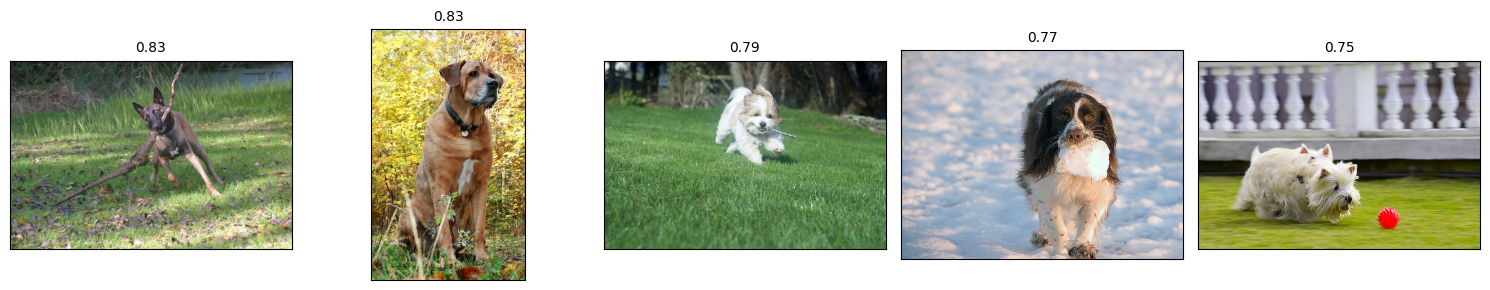

Искомое изображение (из test_queries):


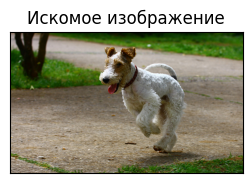

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

-------------------- A group of people are ice skating in a big city . --------------------
Топ-5 изображений. Интервал Score: [0.004, 0.591]


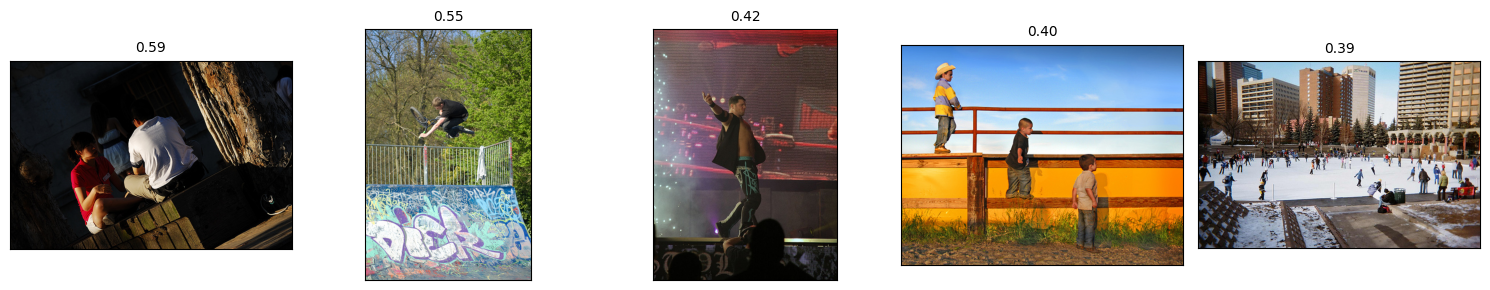

Искомое изображение (из test_queries):


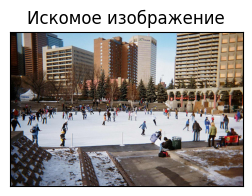


-------------------- Little kid in blue coat and hat riding a tricycle . --------------------

Это изображение недоступно в вашей стране в соответствии с местными законами.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

-------------------- Two black dogs fighting over an orange toy . --------------------
Топ-5 изображений. Интервал Score: [0.000, 0.482]


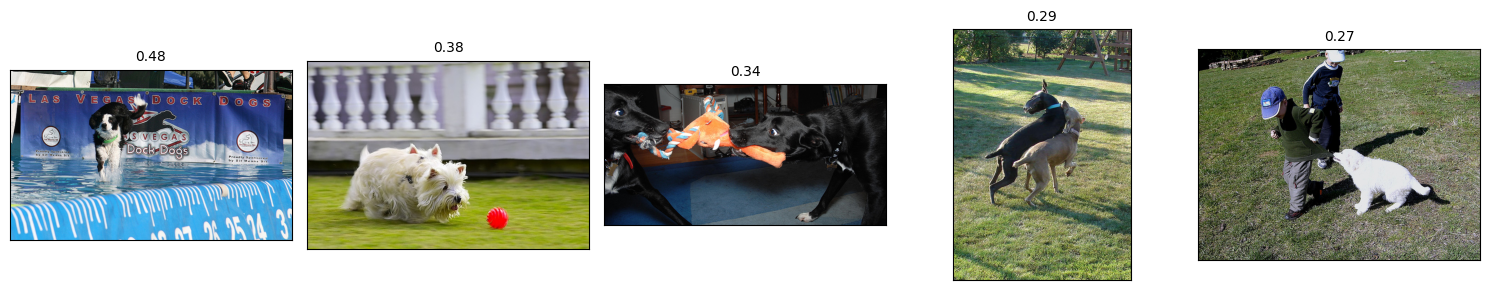

Искомое изображение (из test_queries):


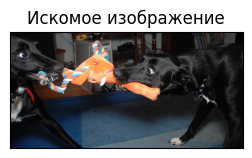

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

-------------------- A dog jumping for a tennis ball near an ocean --------------------
Топ-5 изображений. Интервал Score: [0.000, 0.575]


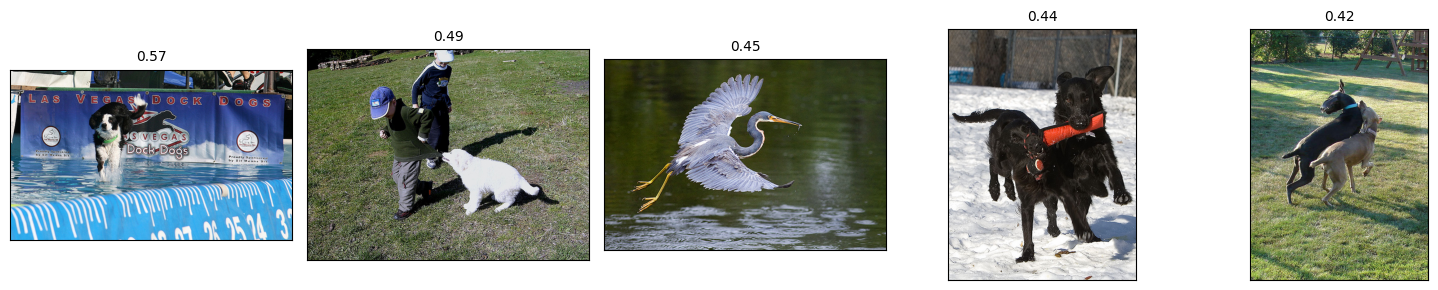

Искомое изображение (из test_queries):


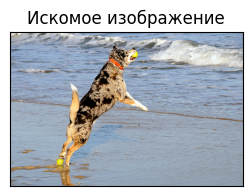


-------------------- Boy flying a distant kite . --------------------

Это изображение недоступно в вашей стране в соответствии с местными законами.


-------------------- kids play ultimate Frisbee . --------------------

Это изображение недоступно в вашей стране в соответствии с местными законами.


-------------------- A girl in a purple shirt feeding ducks --------------------

Это изображение недоступно в вашей стране в соответствии с местными законами.



In [ ]:
# --- Визуализация Top-K только для simple_model ---

def show_topk_images(text: str, k: int = 5):
    preds, tag = predict_scores_for_text(text)
    if preds is None and tag == 'BLOCKED':
        print('\n' + '-'*20, text, '-'*20)
        print('\nThis image is unavailable in your country in compliance with local laws.\n')
        return
    df_scores = pd.DataFrame({'image': test_image_filenames, 'score': preds})
    top = df_scores.sort_values('score', ascending=False).head(k)

    print(f"\n{'-'*20} {text} {'-'*20}")
    print(f'Топ-{k} изображений. Интервал Score: [{preds.min():.3f}, {preds.max():.3f}]')

    fig = plt.figure(figsize=(3*k, 3))
    for i,(img_name, score) in enumerate(zip(top['image'], top['score'])):
        ax = fig.add_subplot(1, k, i+1)
        image = Image.open(Path(test_dir, img_name))
        ax.imshow(image)
        ax.set_title(f'{score:.2f}', fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

    if text in set(df_queries['query_text']):
        true_img = df_queries.loc[df_queries['query_text'] == text, 'image'].iloc[0]
        print('Искомое изображение (из test_queries):')
        plt.figure(figsize=(3,3))
        plt.imshow(Image.open(Path(test_dir, true_img)))
        plt.xticks([]); plt.yticks([])
        plt.title('Искомое изображение')
        plt.show()

# --- Пример: 10 случайных запросов ---
try:
    sample_queries = df_queries.sample(10, random_state=RAND_STATE)['query_text'].tolist()
    for q in sample_queries:
        show_topk_images(q, k=5)
except Exception as e:
    print('Demo error:', e)

## Результаты разработки PoC для поиска изображений

**Цель проекта:** Разработать и обучить демонстрационную модель, которая оценивает семантическую близость между изображением и текстовым запросом, возвращая значение от 0 до 1.

**Архитектура решения:**
- **Векторизация изображений:** Использована предобученная модель **ResNet50**.
- **Векторизация текста:** Использована модель **distilbert-base-uncased**.
- **Модель оценки:** Обучен **многослойный перцептрон (MLP)** на объединённых векторных представлениях для предсказания оценки схожести.

**Обучение и оценка:**
- В качестве целевой переменной использовались оценки экспертов (`expert`: 5822 примера).
- Проведено сравнение с Dummy-моделью и базовой нейросетью.
- Итоговая MLP-модель показала наилучшее качество на валидации.

**Ключевые метрики (Simple MLP):**
- **MAE:** 0.1581
- **R²:** 0.3593
- **Прирост MAE** по сравнению с Dummy-моделью: **0.0688**

**Выводы и наблюдения:**
- Разработанный PoC показывает низкую стабильность в предоставлении релевантных результатов. Лишь в редких случаях в поисковую выдачу попадает полностью соответствующее изображение.
- Наиболее предсказуемые результаты модель демонстрирует на часто встречающихся в запросах объектах, например, **собаках** (слово `dog` — самое частотное).
- Вероятная причина низкой точности — **недостаточный объём данных** для обучения (`train_dataset`: 5822 примера). Модели не хватает разнообразия для выявления сложных семантических связей.
- Возможно стоит попробовать использовать также CrowdAnnotations для улучшения результата поиска
- Для улучшения качества рекомендуется **существенное увеличение объёма обучающей выборки** и, возможно, использование более сложных архитектур для объединения модальностей.